# Introduction
In this notebook, we will use a very simple pandas dataframe to benchmark BC and MMseq dataset for 3-fold cross validation. These dataframes are stored in `DIR_DerivedData + "/3CvFoldReference_%s_%s_%s.pkl" %(User_Task, User_ClusterType, ClanGraphBcPercent)`. The dataframe is formatted to contain the following columns

* `3CVCrossFoldIndex` - Either 0,1 or 2 indicating the Testing fold in a 3-fold cross validation.
* `GenericFilename` - in the format of {pdbid}{conformationid} e.g. `2xs500000000`
* `Task` - Either AUCG or SXPR
* `SequenceHomology_ClusterType` - The sequence homology clustering algorithm. Either BC or Mmseq
* `SequenceHomology_Percent` - The sequence homology percentage. Either 30,40,50,60,70,90,95,100.
* `SequenceHomology_Clan` - The clan id as described in Notebook01
* `FilePath_HaloCoordinate`, `FilePath_ApoPdbCoordinate`, `FilePath_Label`, `FilePath_FeatureAltman` - File location of Apo sanitized structures, Class Labels, Altman feature, and Halos (coordinates with respect to the levitated surface above the protein)
* `Class_Name_%s`, `Class_HaloIndex_%s` - Indices to halo and corresponding class labels `%s`. The biological name of class labels e.g. A,U,C,G is stored in `Class_Name_%s`

# Examples to use the dataframe
As an example,

* We will benchmark the trained NucleicNet using the dataframe. This will produce figures similar (almost exactly the same!) to `Notebook06`. 
* We will also use scipy incremental SVM as an example of external program using the dataframe.

We understand our code is quite long. We hope this helps the reader by pulling out all the necessary codes from the very long `commandBenchmark` called in `Notebook06`.




In [1]:
# ============== Click Please.Imports
import sys
import glob
import gc
import io

import random
random.seed(42)
import pandas as pd
import numpy as np
import networkx as nx

from scipy import sparse
import torch
import seaborn as sns

import matplotlib.pyplot as plt


import time
import tqdm
import collections


import functools
import itertools
import multiprocessing



import torch 
from torch import nn

import torchvision as tv
import pytorch_lightning as pl


sys.path.append('../')
from NucleicNet.DatasetBuilding.util import *

from NucleicNet import Burn, Fuel
import NucleicNet.Burn.util
import NucleicNet.Burn.M1
import  NucleicNet.Burn.DA
%config InlineBackend.figure_format = 'svg'

sns.set_context("notebook")



# Turn on cuda optimizer
print(torch.backends.cudnn.is_available())
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
# disable debugs NOTE use only after debugging
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
# Disable gradient tracking
#torch.no_grad()
#torch.inference_mode()




True


# Test on our trained NucleicNet for Mmseq90 AUCG

In the following two cells, we illutrate on how to benchmark an external trained program using the `CvFoldDf` obtained. We will benchmark our own NucleicNet first. The expected behaviour is to obtain very similar top1/top2 accuracy plot as in `Notebook06` with the very simple `CvFoldDf` instead of the very long protocol in `commandBenchmark`. (We hope this helps the reader by pulling out all the necessary codes!) As the Altman features are large in storage size we will assume they were already produced and stored in `../Database-PDB/feature/`.


## Segment of Code the user may modify

Task, Cluster type and Sequence Homology Percent defines the scope of the test. The can be indicated at

```

# ==================================================
# Indication of task and Sequence Homoology
# =============================================================


User_Task = 'AUCG'
User_ClusterType = "Mmseq"
User_SequenceHomologyPercent = 90
```


A user defined model should be placed at

```

    # ===============================
    # User insert model here
    # ===============================
    # NOTE User should have trained a model which receive no gradient from ValTest sets
    CorrespondingCheckpointsWhichExcludesValTestData = {
                0:"../Models/AUCG-9CVMm90_AUCG-9CVMm90/48_49/checkpoints/epoch=12-step=42703-hp_metric=0.47925713658332825.ckpt",
                1:"../Models/AUCG-9CVMm90_AUCG-9CVMm90/50_51/checkpoints/epoch=12-step=43961-hp_metric=0.4519999921321869.ckpt",
                2:"../Models/AUCG-9CVMm90_AUCG-9CVMm90/52_53/checkpoints/epoch=12-step=42941-hp_metric=0.4690285623073578.ckpt"
    }
    LoadCkpStateIntoModelC = commandBenchmark.LoadCkpStateIntoModel()
    model, ckp_hyperparam, checkpoint = LoadCkpStateIntoModelC.B1hw_LayerResnetBottleneck(CKPT_PATH =CorrespondingCheckpointsWhichExcludesValTestData[test_fold])
    model.to(torch.device('cuda'))
    model.eval()


```


98it [06:12,  2.42s/it]

Cuda run out of memory at 2xs500000000 retrial 0 or run it later!


313it [06:36,  1.27s/it]
313it [00:02, 121.31it/s]
313it [00:00, 8994.12it/s]
313it [00:00, 9598.09it/s]
313it [00:00, 9601.88it/s]
313it [00:00, 9682.68it/s]
313it [00:00, 9471.44it/s]
313it [00:00, 9868.58it/s]
313it [00:00, 9794.29it/s]
313it [00:00, 9421.61it/s]
313it [08:04,  1.55s/it]
313it [00:00, 9572.34it/s]
313it [00:00, 9688.19it/s]
313it [00:00, 9838.33it/s]
313it [00:00, 9662.66it/s]
313it [00:00, 9733.94it/s]
313it [00:00, 9692.55it/s]
313it [00:00, 9728.53it/s]
313it [00:00, 9583.73it/s]
313it [00:00, 9655.84it/s]
258it [02:47,  3.70s/it]

Cuda run out of memory at 5wzk00000000 retrial 0 or run it later!


259it [02:52,  4.19s/it]

Cuda run out of memory at 5wzk00000001 retrial 0 or run it later!


306it [05:27,  2.88s/it]

Cuda run out of memory at 4jvy00000000 retrial 0 or run it later!


313it [05:50,  1.12s/it]
0it [00:00, ?it/s]

Cuda run out of memory at 5wzk00000000 retrial 1 or run it later!


259it [00:05, 48.64it/s]

Cuda run out of memory at 5wzk00000001 retrial 1 or run it later!


264it [00:10, 20.51it/s]

Cuda run out of memory at 4jvy00000000 retrial 1 or run it later!


313it [00:16, 19.42it/s]
0it [00:00, ?it/s]

Cuda run out of memory at 5wzk00000000 retrial 2 or run it later!


259it [00:05, 48.49it/s]

Cuda run out of memory at 5wzk00000001 retrial 2 or run it later!


264it [00:10, 20.46it/s]

Cuda run out of memory at 4jvy00000000 retrial 2 or run it later!


313it [00:16, 19.40it/s]
0it [00:00, ?it/s]

Cuda run out of memory at 5wzk00000000 retrial 3 or run it later!


259it [00:05, 48.62it/s]

Cuda run out of memory at 5wzk00000001 retrial 3 or run it later!


264it [00:10, 20.56it/s]

Cuda run out of memory at 4jvy00000000 retrial 3 or run it later!


313it [00:16, 19.42it/s]
0it [00:00, ?it/s]

Cuda run out of memory at 5wzk00000000 retrial 4 or run it later!


259it [00:05, 47.82it/s]

Cuda run out of memory at 5wzk00000001 retrial 4 or run it later!


264it [00:10, 20.44it/s]

Cuda run out of memory at 4jvy00000000 retrial 4 or run it later!


313it [00:16, 19.33it/s]
0it [00:00, ?it/s]

Cuda run out of memory at 5wzk00000000 retrial 5 or run it later!


259it [00:05, 48.58it/s]

Cuda run out of memory at 5wzk00000001 retrial 5 or run it later!


264it [00:10, 20.64it/s]

Cuda run out of memory at 4jvy00000000 retrial 5 or run it later!


313it [00:16, 19.49it/s]
0it [00:00, ?it/s]

Cuda run out of memory at 5wzk00000000 retrial 6 or run it later!


259it [00:05, 48.45it/s]

Cuda run out of memory at 5wzk00000001 retrial 6 or run it later!


264it [00:10, 20.61it/s]

Cuda run out of memory at 4jvy00000000 retrial 6 or run it later!


313it [00:16, 19.43it/s]
0it [00:00, ?it/s]

Cuda run out of memory at 5wzk00000000 retrial 7 or run it later!


259it [00:05, 48.54it/s]

Cuda run out of memory at 5wzk00000001 retrial 7 or run it later!


264it [00:10, 20.56it/s]

Cuda run out of memory at 4jvy00000000 retrial 7 or run it later!


313it [00:16, 19.42it/s]
0it [00:00, ?it/s]

Cuda run out of memory at 5wzk00000000 retrial 8 or run it later!


259it [00:05, 48.53it/s]

Cuda run out of memory at 5wzk00000001 retrial 8 or run it later!


264it [00:10, 20.58it/s]

Cuda run out of memory at 4jvy00000000 retrial 8 or run it later!


313it [00:16, 19.44it/s]
0it [00:00, ?it/s]

Cuda run out of memory at 5wzk00000000 retrial 9 or run it later!


259it [00:05, 48.53it/s]

Cuda run out of memory at 5wzk00000001 retrial 9 or run it later!


264it [00:10, 20.60it/s]

Cuda run out of memory at 4jvy00000000 retrial 9 or run it later!


313it [00:16, 19.46it/s]


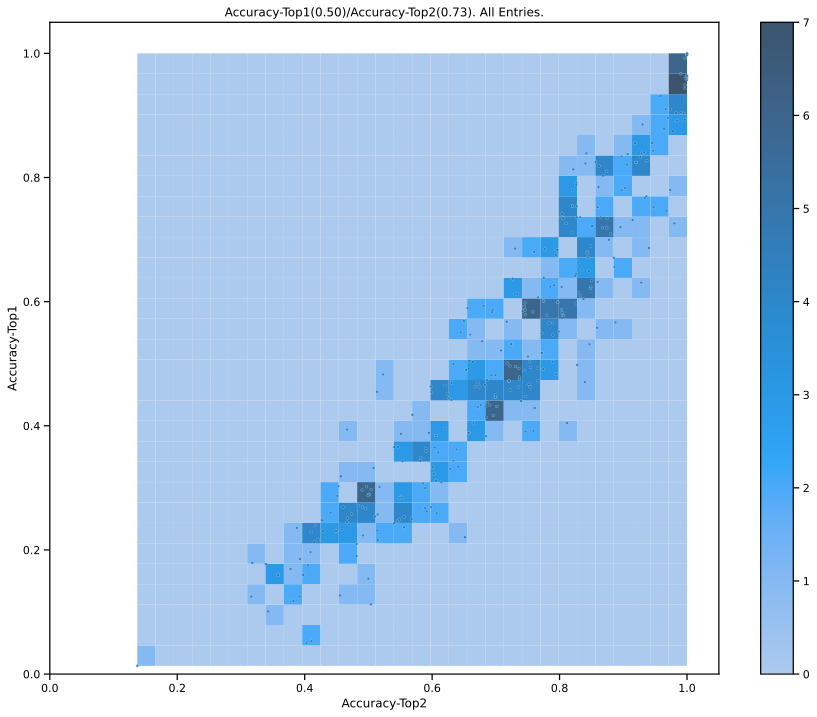

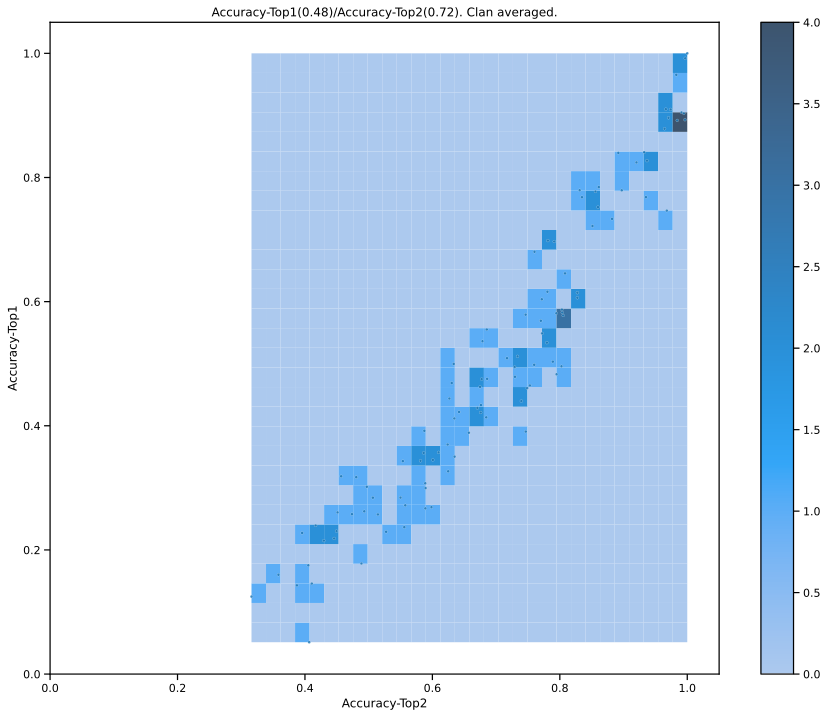

In [3]:
import numpy as np
from sklearn import linear_model
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import top_k_accuracy_score
from  NucleicNet.DatasetBuilding import commandBenchmark
from  NucleicNet.Fuel.DS3 import BasicMap
import torchmetrics

# ==================================================
# Indication of task and Sequence Homoology
# =============================================================


User_Task = 'AUCG'
User_ClusterType = "Mmseq"
User_SequenceHomologyPercent = 90







# ==============================
# UNCHANGED
# ===============================
DIR_DerivedData = "../Database-PDB/DerivedData/"
DIR_Typi = "../Database-PDB/typi/"
DIR_FuelInput = "../Database-PDB/feature/"

n_CrossFold = 9
User_featuretype = 'altman'
n_row_maxhold = 10000


CvFoldDf = pd.read_pickle(DIR_DerivedData + "/3CvFoldReference_%s_%s_%s.pkl" %(User_Task, User_ClusterType, User_SequenceHomologyPercent))
grandbenchmark_df  =CvFoldDf.drop(columns=["Class_HaloIndex_%s" %(i_class) for i_class in range(4)])



if User_ClusterType == "Mmseq":
    from NucleicNet.DatasetBuilding.commandDataFetcherMmseq import FetchIndex, FetchTask, FetchDataset, TEMPLATE_TaskNameLabelLogicDict
else:
    from NucleicNet.DatasetBuilding.commandDataFetcher import FetchIndex, FetchTask, FetchDataset, TEMPLATE_TaskNameLabelLogicDict


TaskNameLabelLogicDict = TEMPLATE_TaskNameLabelLogicDict()




FetchIndexC = FetchIndex(DIR_Feature = DIR_FuelInput, 
                        DIR_Typi =  DIR_Typi, n_row_maxhold =  n_row_maxhold)





with open(DIR_DerivedData + "Feature.IPCA.altman.AUCG.pkl", "rb") as fn: 
    IPCA = pickle.load(fn)
IPCA_Std = (IPCA.var_)**0.5 # NOTE The statistics are caclaulted from AUCG (we avoided collecting it from all datapoints as it was swamped with nonsites), but can be applied to any dataset. There is no Feature.IPCA.altman.SXPR.pkl

# ========================
# Trained Model
# =========================
from NucleicNet.DatasetBuilding.commandServer import Server
pdbid_done = []
for test_fold in [0,1,2]:

    # ===============================
    # User insert model here
    # ===============================
    # NOTE User should have trained a model which receive no gradient from ValTest sets
    CorrespondingCheckpointsWhichExcludesValTestData = {
                0:"../Models/AUCG-9CVMm90_AUCG-9CVMm90/48_49/checkpoints/epoch=12-step=42703-hp_metric=0.47925713658332825.ckpt",
                1:"../Models/AUCG-9CVMm90_AUCG-9CVMm90/50_51/checkpoints/epoch=12-step=43961-hp_metric=0.4519999921321869.ckpt",
                2:"../Models/AUCG-9CVMm90_AUCG-9CVMm90/52_53/checkpoints/epoch=12-step=42941-hp_metric=0.4690285623073578.ckpt"
    }
    LoadCkpStateIntoModelC = commandBenchmark.LoadCkpStateIntoModel()
    model, ckp_hyperparam, checkpoint = LoadCkpStateIntoModelC.B1hw_LayerResnetBottleneck(CKPT_PATH =CorrespondingCheckpointsWhichExcludesValTestData[test_fold])
    model.to(torch.device('cuda'))
    model.eval()


    # =================================
    # Scoring Top1/2 accuracy
    # =================================

    for retrial_i in range(100):
        for row_i , row in tqdm.tqdm(CvFoldDf.iterrows()):
            with torch.no_grad():
                currentfold = row['3CVCrossFoldIndex']
                if currentfold != test_fold:
                    continue

                genericfn = row['GenericFilename']

                if genericfn in pdbid_done:
                    continue
                currentfold = row['3CVCrossFoldIndex']
                n_class = len(TaskNameLabelLogicDict[User_Task])



                try:
                    # ===================
                    # Retrieve label feature
                    # ======================
                    y = []
                    x = []

                    for i_class in range(n_class):
                        indicesretrieve = row["Class_HaloIndex_%s" %(i_class)]
                        if len(indicesretrieve) == 0:
                            continue
                        y.extend([i_class for ii in range(len(indicesretrieve))])
                        # NOTE Retrieval of vectors
                        feat = FetchIndexC.UTIL_Index_Feature(np.array(indicesretrieve, dtype=np.int32), 
                                                    pdbid = genericfn, featuretype = "altman", ReturnDense = True)
                        x.append(feat)



                    train_x = np.concatenate(x, axis= 0)
                    truey = np.array(y, dtype=np.int32)

                    #sampling_weight = compute_sample_weight(class_weight = None, y = truey)
                    truey = torch.LongTensor(truey)
                    #truey = truey.to('cuda')
                    # =================================
                    # Some tidy up on the Altman feature
                    # =================================
                    train_x = torch.FloatTensor(train_x)
                    train_x /= torch.FloatTensor(IPCA_Std)
                    train_x = torch.nan_to_num(train_x, nan = 0.0, posinf = 0.0, neginf = 0.0)
                    train_x_size = train_x.shape[0]
                    feature_resizeshape  =(6,80)
                    train_x.resize_((train_x_size, *feature_resizeshape)).unsqueeze_(1)
                    train_x = torch.nan_to_num(train_x, nan = 0.0, posinf = 0.0, neginf = 0.0)
                    sign = train_x.sign()
                    train_x.abs_()
                    train_x[train_x <= 1e-6] = 0.0
                    train_x *= sign

                    # NOTE a dummy inserted to prevent cheating!
                    dummy_y = [0 for i in range(train_x.shape[0])]
                    dummy_y = np.array(dummy_y, dtype= int)
                    dummy_yyyy = torch.nn.functional.one_hot(torch.LongTensor(dummy_y).type(torch.int64), num_classes= n_class).type(torch.float32)
                    dummy_y = torch.LongTensor(dummy_y)

                    


                    #train_x = train_x.to("cuda")
                    #dummy_y = dummy_y.to("cuda")
                    #dummy_yyyy = dummy_yyyy.to("cuda")


                    test_loader_t          = torch.utils.data.DataLoader(BasicMap(train_x, dummy_y, dummy_yyyy), 
                                                                        batch_size=1024, 
                                                                        drop_last=False, num_workers=4, 
                                                                        pin_memory=True,worker_init_fn=None, 
                                                                        prefetch_factor=3, persistent_workers=False,
                                                                        shuffle=False)

                    # =================================
                    # Get Prediction
                    # =================================
                    p_list = []                
                    for _, xy in enumerate(test_loader_t):
                        # TODO Get the index in halo and the xyz coordinate of halo here.

                        tempx = xy[0] 
                        tempy = xy[1]
                        tempx = tempx.to('cuda')
                        tempy = tempy.to('cuda')
                        p = model.predict_step((tempx,tempy),0)

                        p_list.append(p)

                        del tempx,tempy
                        gc.collect()


                    p = torch.cat(p_list)
                    p = p.detach().cpu()#.numpy()




                    top1 = torchmetrics.functional.accuracy(p, truey, top_k =1, average = 'weighted', num_classes = n_class).cpu().numpy()
                    top2 = torchmetrics.functional.accuracy(p, truey, top_k =2, average = 'weighted', num_classes = n_class).cpu().numpy()
                    grandbenchmark_df.loc[row_i, "Accuracy-Top1"] = top1
                    grandbenchmark_df.loc[row_i, "Accuracy-Top2"] = top2

                    #print(top1, top2)



                    pdbid_done.append(genericfn)
                    del p, p_list, train_x, dummy_y, dummy_yyyy, truey
                    NucleicNet.Burn.util.TorchEmptyCache()
                    gc.collect()
                    time.sleep(1)

                except RuntimeError:
                    NucleicNet.Burn.util.TorchEmptyCache()
                    time.sleep(4)
                    print("Cuda run out of memory at %s retrial %s or run it later!" %(genericfn, retrial_i))
                    NucleicNet.Burn.util.TorchEmptyCache()
                    time.sleep(4)
                    #NucleicNet.Burn.util.TorchEmptyCache()




plt.figure(figsize = (15,12))
g = sns.histplot(data=grandbenchmark_df, y="Accuracy-Top1", x="Accuracy-Top2", kde=False, bins = 30, palette='YlGnBu', thresh = None, cbar = True)
sns.scatterplot(data=grandbenchmark_df, y="Accuracy-Top1", x="Accuracy-Top2", 
                marker = 'o', s = 8.0, alpha = 0.8)

plt.title("Accuracy-Top1(%.2f)/Accuracy-Top2(%.2f). All Entries." %(grandbenchmark_df["Accuracy-Top1"].median(),grandbenchmark_df["Accuracy-Top2"].median() ))
plt.xlim((0,1.05))
plt.ylim((0,1.05))
plt.show()

# ===================
# Clan averaged
# ==================

grandbenchmark_df_ClanGrouped = grandbenchmark_df.groupby(by=["SequenceHomology_Clan"] ).agg('mean').reset_index()


plt.figure(figsize = (15,12))
g = sns.histplot(data=grandbenchmark_df_ClanGrouped, y="Accuracy-Top1", x="Accuracy-Top2", kde=False, bins = 30, palette='YlGnBu', thresh = None, cbar = True)
sns.scatterplot(data=grandbenchmark_df_ClanGrouped, y="Accuracy-Top1", x="Accuracy-Top2", 
                marker = 'o', s = 8.0, palette='husl', alpha = 0.8)

plt.title("Accuracy-Top1(%.2f)/Accuracy-Top2(%.2f). Clan averaged." %(grandbenchmark_df_ClanGrouped["Accuracy-Top1"].median(),grandbenchmark_df_ClanGrouped["Accuracy-Top2"].median()))
plt.xlim((0,1.05))
plt.ylim((0,1.05))
plt.show()




# Test on our trained NucleicNet for Mmseq90 SXPR

100%|██████████| 100/100 [4:03:42<00:00, 146.22s/it]


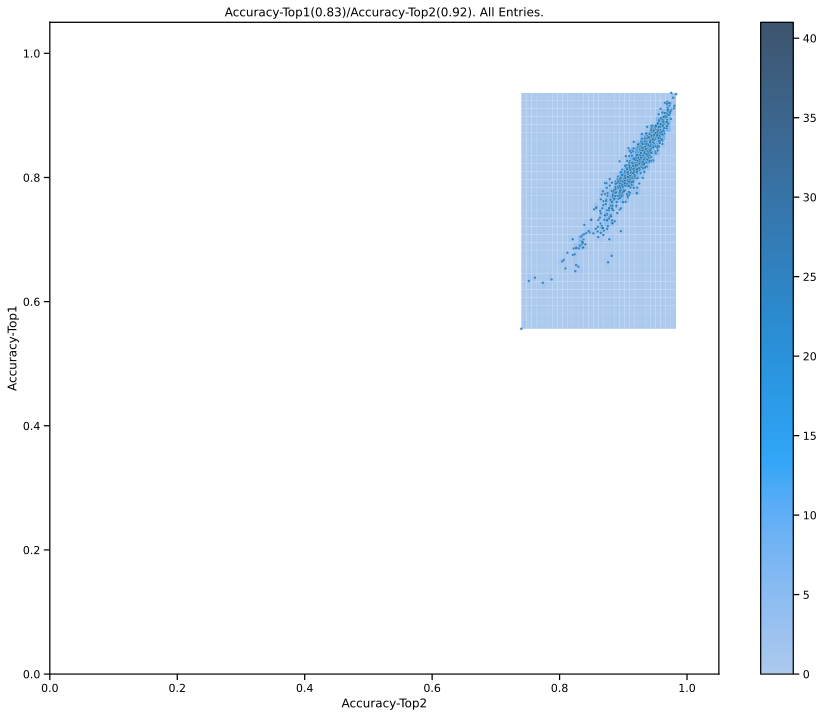

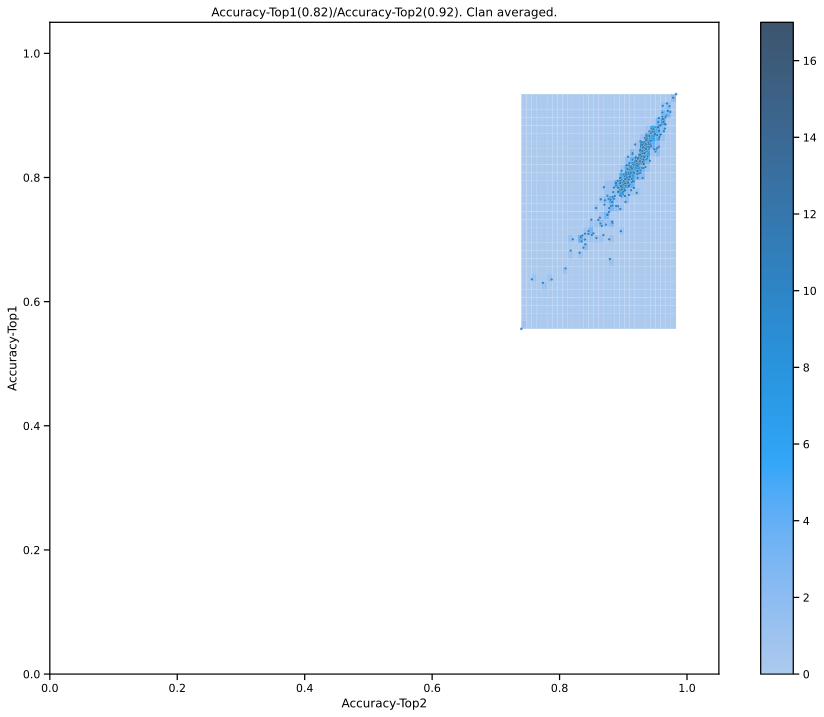

In [3]:
import numpy as np
from sklearn import linear_model
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import top_k_accuracy_score
from  NucleicNet.DatasetBuilding import commandBenchmark
from  NucleicNet.Fuel.DS3 import BasicMap
import torchmetrics

# ==================================================
# Indication of task and Sequence Homoology
# =============================================================


User_Task = 'SXPR'
User_ClusterType = "Mmseq"
User_SequenceHomologyPercent = 90







# ==============================
# UNCHANGED
# ===============================
DIR_DerivedData = "../Database-PDB/DerivedData/"
DIR_Typi = "../Database-PDB/typi/"
DIR_FuelInput = "../Database-PDB/feature/"

n_CrossFold = 9
User_featuretype = 'altman'
n_row_maxhold = 10000


CvFoldDf = pd.read_pickle(DIR_DerivedData + "/3CvFoldReference_%s_%s_%s.pkl" %(User_Task, User_ClusterType, User_SequenceHomologyPercent))
grandbenchmark_df  =CvFoldDf.drop(columns=["Class_HaloIndex_%s" %(i_class) for i_class in range(4)])




if User_ClusterType == "Mmseq":
    from NucleicNet.DatasetBuilding.commandDataFetcherMmseq import FetchIndex, FetchTask, FetchDataset, TEMPLATE_TaskNameLabelLogicDict
else:
    from NucleicNet.DatasetBuilding.commandDataFetcher import FetchIndex, FetchTask, FetchDataset, TEMPLATE_TaskNameLabelLogicDict


TaskNameLabelLogicDict = TEMPLATE_TaskNameLabelLogicDict()



FetchIndexC = FetchIndex(DIR_Feature = DIR_FuelInput, 
                        DIR_Typi =  DIR_Typi, n_row_maxhold =  n_row_maxhold)





with open(DIR_DerivedData + "Feature.IPCA.altman.AUCG.pkl", "rb") as fn: 
    IPCA = pickle.load(fn)
IPCA_Std = (IPCA.var_)**0.5 # NOTE The statistics are caclaulted from AUCG (we avoided collecting it from all datapoints as it was swamped with nonsites), but can be applied to any dataset. There is no Feature.IPCA.altman.SXPR.pkl

# ========================
# Trained Model
# =========================
from NucleicNet.DatasetBuilding.commandServer import Server
pdbid_done = []
for test_fold in [0,1,2]:

    # ===============================
    # User insert model here
    # ===============================
    # NOTE User should have trained a model which receive no gradient from ValTest sets
    CorrespondingCheckpointsWhichExcludesValTestData = {
                0:"../Models/SXPR-9CVMm90_SXPR-9CVMm90/6_7/checkpoints/epoch=0-step=21564-hp_metric=0.5079357028007507.ckpt",
                1:"../Models/SXPR-9CVMm90_SXPR-9CVMm90/8_9/checkpoints/epoch=2-step=66455-hp_metric=0.5010985732078552.ckpt",
                2:"../Models/SXPR-9CVMm90_SXPR-9CVMm90/10_11/checkpoints/epoch=2-step=67817-hp_metric=0.5154971480369568.ckpt",
    }
    LoadCkpStateIntoModelC = commandBenchmark.LoadCkpStateIntoModel()
    model, ckp_hyperparam, checkpoint = LoadCkpStateIntoModelC.B1hw_LayerResnetBottleneck(CKPT_PATH =CorrespondingCheckpointsWhichExcludesValTestData[test_fold])
    model.to(torch.device('cuda'))
    model.eval()
                                            
                                            


    # =================================
    # Scoring Top1/2 accuracy
    # =================================

    for retrial_i in tqdm.tqdm(range(100)):
        for row_i , row in CvFoldDf.iterrows():
            with torch.no_grad():
                currentfold = row['3CVCrossFoldIndex']
                if currentfold != test_fold:
                    continue

                genericfn = row['GenericFilename']

                if genericfn in pdbid_done:
                    continue
                currentfold = row['3CVCrossFoldIndex']
                n_class = len(TaskNameLabelLogicDict[User_Task])



                try:
                    # ===================
                    # Retrieve label feature
                    # ======================
                    y = []
                    x = []

                    for i_class in range(n_class):
                        indicesretrieve = row["Class_HaloIndex_%s" %(i_class)]
                        if len(indicesretrieve) == 0:
                            continue
                        y.extend([i_class for ii in range(len(indicesretrieve))])
                        # NOTE Retrieval of vectors
                        feat = FetchIndexC.UTIL_Index_Feature(np.array(indicesretrieve, dtype=np.int32), 
                                                    pdbid = genericfn, featuretype = "altman", ReturnDense = True)
                        x.append(feat)



                    train_x = np.concatenate(x, axis= 0)
                    truey = np.array(y, dtype=np.int32)

                    #sampling_weight = compute_sample_weight(class_weight = None, y = truey)
                    truey = torch.LongTensor(truey)
                    #truey = truey.to('cuda')
                    # =================================
                    # Some tidy up on the Altman feature
                    # =================================
                    train_x = torch.FloatTensor(train_x)
                    train_x /= torch.FloatTensor(IPCA_Std)
                    train_x = torch.nan_to_num(train_x, nan = 0.0, posinf = 0.0, neginf = 0.0)
                    train_x_size = train_x.shape[0]
                    feature_resizeshape  =(6,80)
                    train_x.resize_((train_x_size, *feature_resizeshape)).unsqueeze_(1)
                    train_x = torch.nan_to_num(train_x, nan = 0.0, posinf = 0.0, neginf = 0.0)
                    sign = train_x.sign()
                    train_x.abs_()
                    train_x[train_x <= 1e-6] = 0.0
                    train_x *= sign

                    # NOTE a dummy inserted to prevent cheating!
                    dummy_y = [0 for i in range(train_x.shape[0])]
                    dummy_y = np.array(dummy_y, dtype= int)
                    dummy_yyyy = torch.nn.functional.one_hot(torch.LongTensor(dummy_y).type(torch.int64), num_classes= n_class).type(torch.float32)
                    dummy_y = torch.LongTensor(dummy_y)

                    


                    #train_x = train_x.to("cuda")
                    #dummy_y = dummy_y.to("cuda")
                    #dummy_yyyy = dummy_yyyy.to("cuda")


                    test_loader_t          = torch.utils.data.DataLoader(BasicMap(train_x, dummy_y, dummy_yyyy), 
                                                                        batch_size=1024, 
                                                                        drop_last=False, num_workers=4, 
                                                                        pin_memory=True,worker_init_fn=None, 
                                                                        prefetch_factor=3, persistent_workers=False,
                                                                        shuffle=False)

                    # =================================
                    # Get Prediction
                    # =================================
                    p_list = []                
                    for _, xy in enumerate(test_loader_t):
                        # TODO Get the index in halo and the xyz coordinate of halo here.

                        tempx = xy[0] 
                        tempy = xy[1]
                        tempx = tempx.to('cuda')
                        tempy = tempy.to('cuda')
                        p = model.predict_step((tempx,tempy),0)

                        p_list.append(p)

                        del tempx,tempy
                        gc.collect()


                    p = torch.cat(p_list)
                    p = p.detach().cpu()#.numpy()




                    top1 = torchmetrics.functional.accuracy(p, truey, top_k =1, average = 'weighted', num_classes = n_class).cpu().numpy()
                    top2 = torchmetrics.functional.accuracy(p, truey, top_k =2, average = 'weighted', num_classes = n_class).cpu().numpy()
                    grandbenchmark_df.loc[row_i, "Accuracy-Top1"] = top1
                    grandbenchmark_df.loc[row_i, "Accuracy-Top2"] = top2

                    #print(top1, top2)



                    pdbid_done.append(genericfn)
                    del p, p_list, train_x, dummy_y, dummy_yyyy, truey
                    NucleicNet.Burn.util.TorchEmptyCache()
                    gc.collect()
                    time.sleep(1)

                except RuntimeError:
                    NucleicNet.Burn.util.TorchEmptyCache()
                    time.sleep(4)
                    #print("Cuda run out of memory at %s retrial %s or run it later!" %(genericfn, retrial_i))
                    NucleicNet.Burn.util.TorchEmptyCache()
                    time.sleep(4)
                    #NucleicNet.Burn.util.TorchEmptyCache()




plt.figure(figsize = (15,12))
g = sns.histplot(data=grandbenchmark_df, y="Accuracy-Top1", x="Accuracy-Top2", kde=False, bins = 30, palette='YlGnBu', thresh = None, cbar = True)
sns.scatterplot(data=grandbenchmark_df, y="Accuracy-Top1", x="Accuracy-Top2", 
                marker = 'o', s = 8.0, alpha = 0.8)

plt.title("Accuracy-Top1(%.2f)/Accuracy-Top2(%.2f). All Entries." %(grandbenchmark_df["Accuracy-Top1"].median(),grandbenchmark_df["Accuracy-Top2"].median() ))
plt.xlim((0,1.05))
plt.ylim((0,1.05))
plt.show()

# ===================
# Clan averaged
# ==================

grandbenchmark_df_ClanGrouped = grandbenchmark_df.groupby(by=["SequenceHomology_Clan"] ).agg('mean').reset_index()


plt.figure(figsize = (15,12))
g = sns.histplot(data=grandbenchmark_df_ClanGrouped, y="Accuracy-Top1", x="Accuracy-Top2", kde=False, bins = 30, palette='YlGnBu', thresh = None, cbar = True)
sns.scatterplot(data=grandbenchmark_df_ClanGrouped, y="Accuracy-Top1", x="Accuracy-Top2", 
                marker = 'o', s = 8.0, palette='husl', alpha = 0.8)

plt.title("Accuracy-Top1(%.2f)/Accuracy-Top2(%.2f). Clan averaged." %(grandbenchmark_df_ClanGrouped["Accuracy-Top1"].median(),grandbenchmark_df_ClanGrouped["Accuracy-Top2"].median()))
plt.xlim((0,1.05))
plt.ylim((0,1.05))
plt.show()


# Test on an SVM for AUCG Mmseq90

We will use an sklearn implementation of minibatch SVM as an example. The feature will be altman feature or some random vectors. We will use one designated fold of data for validation; the rest for training. 


* A useful util is `FetchIndexC.UTIL_Index_Feature(np.array(indicesretrieve, dtype=np.int32), pdbid = genericfn, featuretype = "altman", ReturnDense = True)` where the raw altman feature can be retrieved when it has been produced.

0it [00:00, ?it/s]/tmp/ipykernel_1036330/2136977674.py:111: RuntimeWarning: invalid value encountered in true_divide
  x /= IPCA_Std.flatten()
1it [00:03,  3.45s/it]/tmp/ipykernel_1036330/2136977674.py:111: RuntimeWarning: invalid value encountered in true_divide
  x /= IPCA_Std.flatten()
11it [00:28,  1.73s/it]/tmp/ipykernel_1036330/2136977674.py:111: RuntimeWarning: invalid value encountered in true_divide
  x /= IPCA_Std.flatten()
21it [00:36,  1.70it/s]/tmp/ipykernel_1036330/2136977674.py:111: RuntimeWarning: invalid value encountered in true_divide
  x /= IPCA_Std.flatten()
31it [00:51,  1.27s/it]/tmp/ipykernel_1036330/2136977674.py:111: RuntimeWarning: invalid value encountered in true_divide
  x /= IPCA_Std.flatten()
41it [01:31,  5.07s/it]/tmp/ipykernel_1036330/2136977674.py:111: RuntimeWarning: invalid value encountered in true_divide
  x /= IPCA_Std.flatten()
51it [02:22,  5.15s/it]/tmp/ipykernel_1036330/2136977674.py:111: RuntimeWarning: invalid value encountered in true_div

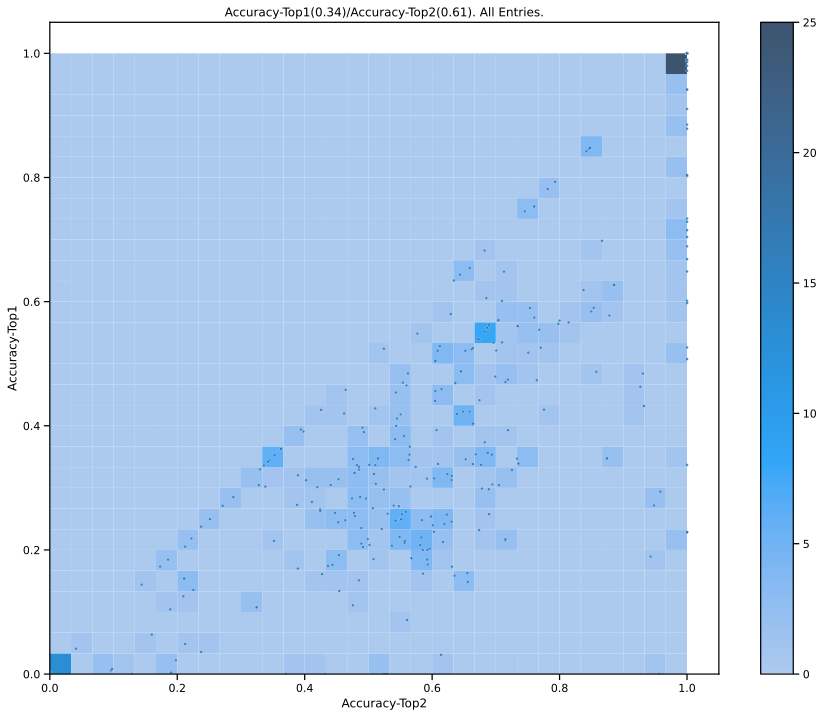

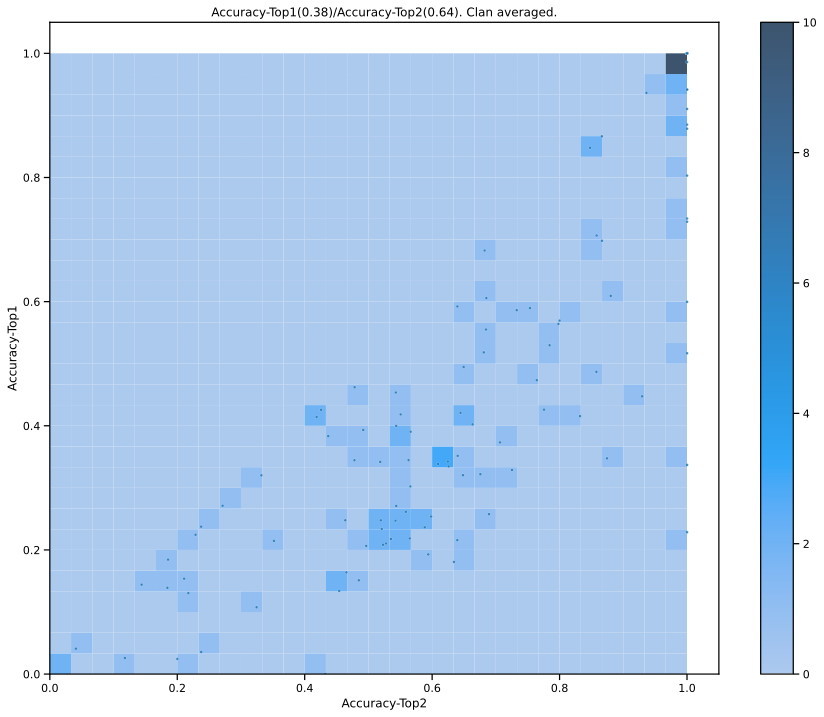

In [2]:
import numpy as np
np.random.seed(0)
from sklearn import linear_model
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import top_k_accuracy_score
User_Task = 'AUCG'
User_ClusterType = "Mmseq"







# ===== Fixed
DIR_DerivedData = "../Database-PDB/DerivedData/"
DIR_Typi = "../Database-PDB/typi/"
DIR_FuelInput = "../Database-PDB/feature/"

n_CrossFold = 9
User_featuretype = 'altman'
n_row_maxhold = 10000

CvFoldDf = pd.read_pickle(DIR_DerivedData + "/3CvFoldReference_%s_%s_%s.pkl" %(User_Task, User_ClusterType, 90))
grandbenchmark_df  =CvFoldDf.drop(columns=["Class_HaloIndex_%s" %(i_class) for i_class in range(4)])










if User_ClusterType == "Mmseq":
    from NucleicNet.DatasetBuilding.commandDataFetcherMmseq import FetchIndex, FetchTask, FetchDataset, TEMPLATE_TaskNameLabelLogicDict
else:
    from NucleicNet.DatasetBuilding.commandDataFetcher import FetchIndex, FetchTask, FetchDataset, TEMPLATE_TaskNameLabelLogicDict



TaskNameLabelLogicDict = TEMPLATE_TaskNameLabelLogicDict()



FetchIndexC = FetchIndex(DIR_Feature = DIR_FuelInput, 
                        DIR_Typi =  DIR_Typi, n_row_maxhold =  n_row_maxhold)



with open(DIR_DerivedData + "Feature.IPCA.altman.AUCG.pkl", "rb") as fn: 
    IPCA = pickle.load(fn)
IPCA_Std = (IPCA.var_)**0.5 # NOTE The statistics are caclaulted from AUCG (we avoided collecting it from all datapoints as it was swamped with nonsites), but can be applied to any dataset. There is no Feature.IPCA.altman.SXPR.pkl

# datalimit*1.5 flush10 0.29/0.62
# datalimit*3  flush10  0.31/0.60
# datalimit*5 flush10 0.33/0.6
# datalinit*10 flush10 0.38/0.64
for test_fold in [0,1,2,]:

    # ===============================
    # User insert model here
    # ===============================
    SGDClassifierC = linear_model.SGDClassifier(loss='hinge', penalty='l2', 
                                            alpha=0.0001, l1_ratio=0.15, fit_intercept=True,  shuffle=False, verbose=0, 
                                            epsilon=0.1, n_jobs=1, random_state=None, learning_rate='optimal', 
                                            eta0=0.0, power_t=0.5, class_weight=None, warm_start=False)

    # ================================
    # Training
    # ================================
    
    traindf = CvFoldDf.loc[CvFoldDf['3CVCrossFoldIndex'] != test_fold]
    jj = 0
    flush_x = []
    flush_y = []
    flush_samplingweight = []
    for retrain_cycle in range(20):
        for row_i , row in tqdm.tqdm(traindf.iterrows()):
            if jj > int(traindf.shape[0] * 10.0) :  # NOTE From experience after that the performance deteriorates
                continue
            # NOTE Training 
            genericfn = row['GenericFilename']
            currentfold = row['3CVCrossFoldIndex']
            n_class = len(TaskNameLabelLogicDict[User_Task])
            # ===================
            # Retrieve label feature
            # ======================
            y = []
            x = []
            
            for i_class in range(n_class):

                indicesretrieve = row["Class_HaloIndex_%s" %(i_class)]

                if len(indicesretrieve) == 0:
                    continue

                indicesretrieve = np.array(indicesretrieve, dtype=np.int32)
                y.extend([i_class for ii in range(len(indicesretrieve))])

                # NOTE Retrieval of vectors
                feat = FetchIndexC.UTIL_Index_Feature(indicesretrieve, 
                                                        pdbid = genericfn, featuretype = "altman", ReturnDense = True)
                x.append(feat)


                #sys.exit()
            x = np.concatenate(x, axis= 0)
            x /= IPCA_Std.flatten()
            x = np.nan_to_num(x, nan = 0.0, posinf = 0.0, neginf = 0.0)
            y = np.array(y, dtype=np.int32)


            flush_x.append(x)
            flush_y.append(y)

            if jj %10 == 0:
                x = np.concatenate(flush_x, axis = 0)
                y = np.concatenate(flush_y, axis = 0)
                # NOTE Placing sampling weight here is very important as the dataset is highly imbalanced.
                sampling_weight = compute_sample_weight(class_weight = None, y = y)
                # NOTE Incremental SVM
                SGDClassifierC.partial_fit(x,y, classes =list(range(n_class)), sample_weight= sampling_weight) 
                flush_x = []
                flush_y = []
                flush_samplingweight = []
            jj +=1

    # =================================
    # Scoring Top1/2 accuracy
    # =================================
    #jj = 0
    for row_i , row in tqdm.tqdm(CvFoldDf.iterrows()):
        currentfold = row['3CVCrossFoldIndex']
        if currentfold != test_fold:
            continue
        #if jj > 20:
        #    continue
        genericfn = row['GenericFilename']
        currentfold = row['3CVCrossFoldIndex']
        n_class = len(TaskNameLabelLogicDict[User_Task])

        # ===================
        # Retrieve label feature
        # ======================
        y = []
        x = []
        for i_class in range(n_class):
            indicesretrieve = row["Class_HaloIndex_%s" %(i_class)]
            if len(indicesretrieve) == 0:
                continue
            y.extend([i_class for ii in range(len(indicesretrieve))])
            # NOTE Retrieval of vectors
            feat = FetchIndexC.UTIL_Index_Feature(np.array(indicesretrieve, dtype=np.int32), 
                                        pdbid = genericfn, featuretype = "altman", ReturnDense = True)
            x.append(feat)

        x = np.concatenate(x, axis= 0)
        x /= IPCA_Std.flatten()
        x = np.nan_to_num(x, nan = 0.0, posinf = 0.0, neginf = 0.0)

        y = np.array(y, dtype=np.int32)
        sampling_weight = compute_sample_weight(class_weight = None, y = y)


        y_pred = SGDClassifierC.predict(x)
        ypred_onehot = np.zeros((y.shape[0], n_class), dtype =np.int32)
        ypred_onehot[np.arange(y_pred.shape[0]), y_pred] = 1

        # NOTE Top accuracys
        top1 = top_k_accuracy_score(y, ypred_onehot, k=1, normalize=True, sample_weight=sampling_weight, labels=list(range(n_class)))
        top2 = top_k_accuracy_score(y, ypred_onehot, k=2, normalize=True, sample_weight=sampling_weight, labels=list(range(n_class)))
        grandbenchmark_df.loc[row_i, "Accuracy-Top1"] = top1
        grandbenchmark_df.loc[row_i, "Accuracy-Top2"] = top2
        #print(top1,top2)
        #print(score) # NOTE which accuracy is it?

        #jj +=1
    del SGDClassifierC
    gc.collect()


plt.figure(figsize = (15,12))
g = sns.histplot(data=grandbenchmark_df, y="Accuracy-Top1", x="Accuracy-Top2", kde=False, bins = 30, palette='YlGnBu', thresh = None, cbar = True)
sns.scatterplot(data=grandbenchmark_df, y="Accuracy-Top1", x="Accuracy-Top2", 
                marker = 'o', s = 8.0, alpha = 0.8)

plt.title("Accuracy-Top1(%.2f)/Accuracy-Top2(%.2f). All Entries." %(grandbenchmark_df["Accuracy-Top1"].median(),grandbenchmark_df["Accuracy-Top2"].median() ))
plt.xlim((0,1.05))
plt.ylim((0,1.05))
plt.show()

# ===================
# Clan averaged
# ==================

grandbenchmark_df_ClanGrouped = grandbenchmark_df.groupby(by=["SequenceHomology_Clan"] ).agg('mean').reset_index()


plt.figure(figsize = (15,12))
g = sns.histplot(data=grandbenchmark_df_ClanGrouped, y="Accuracy-Top1", x="Accuracy-Top2", kde=False, bins = 30, palette='YlGnBu', thresh = None, cbar = True)
sns.scatterplot(data=grandbenchmark_df_ClanGrouped, y="Accuracy-Top1", x="Accuracy-Top2", 
                marker = 'o', s = 8.0, palette='husl', alpha = 0.8)

plt.title("Accuracy-Top1(%.2f)/Accuracy-Top2(%.2f). Clan averaged." %(grandbenchmark_df_ClanGrouped["Accuracy-Top1"].median(),grandbenchmark_df_ClanGrouped["Accuracy-Top2"].median()))
plt.xlim((0,1.05))
plt.ylim((0,1.05))
plt.show()





# Test on an SVM for SXPR Mmseq90



(857, 14)


  0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_520955/3604039602.py:157: RuntimeWarning: invalid value encountered in true_divide
  x /= IPCA_Std.flatten()
/tmp/ipykernel_520955/3604039602.py:157: RuntimeWarning: invalid value encountered in true_divide
  x /= IPCA_Std.flatten()
/tmp/ipykernel_520955/3604039602.py:157: RuntimeWarning: invalid value encountered in true_divide
  x /= IPCA_Std.flatten()
/tmp/ipykernel_520955/3604039602.py:157: RuntimeWarning: invalid value encountered in true_divide
  x /= IPCA_Std.flatten()
/tmp/ipykernel_520955/3604039602.py:157: RuntimeWarning: invalid value encountered in true_divide
  x /= IPCA_Std.flatten()
/tmp/ipykernel_520955/3604039602.py:157: RuntimeWarning: invalid value encountered in true_divide
  x /= IPCA_Std.flatten()
/tmp/ipykernel_520955/3604039602.py:157: RuntimeWarning: invalid value encountered in true_divide
  x /= IPCA_Std.flatten()
/tmp/ipykernel_520955/3604039602.py:157: RuntimeWarning: invalid value encountered in true_divi

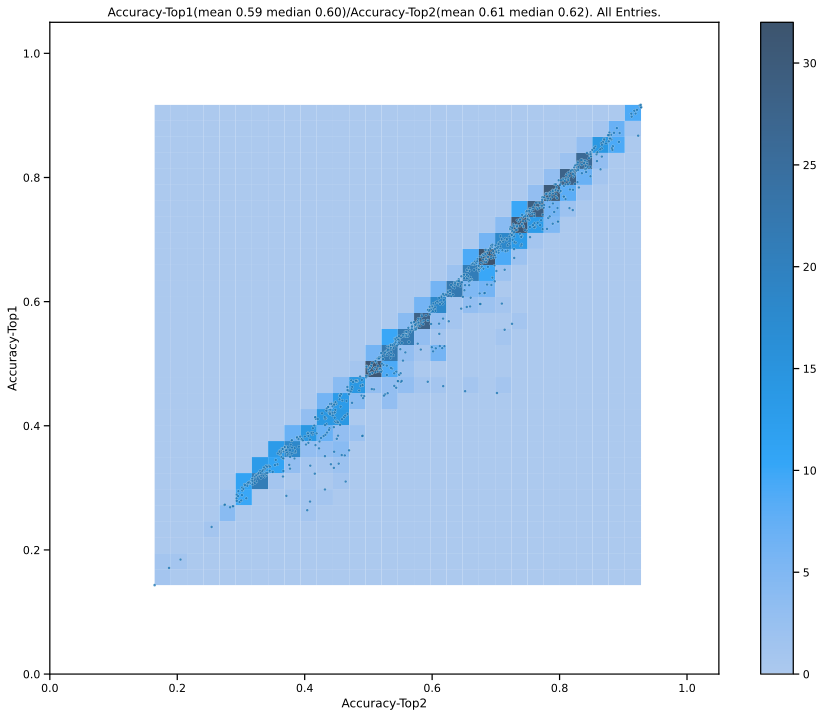

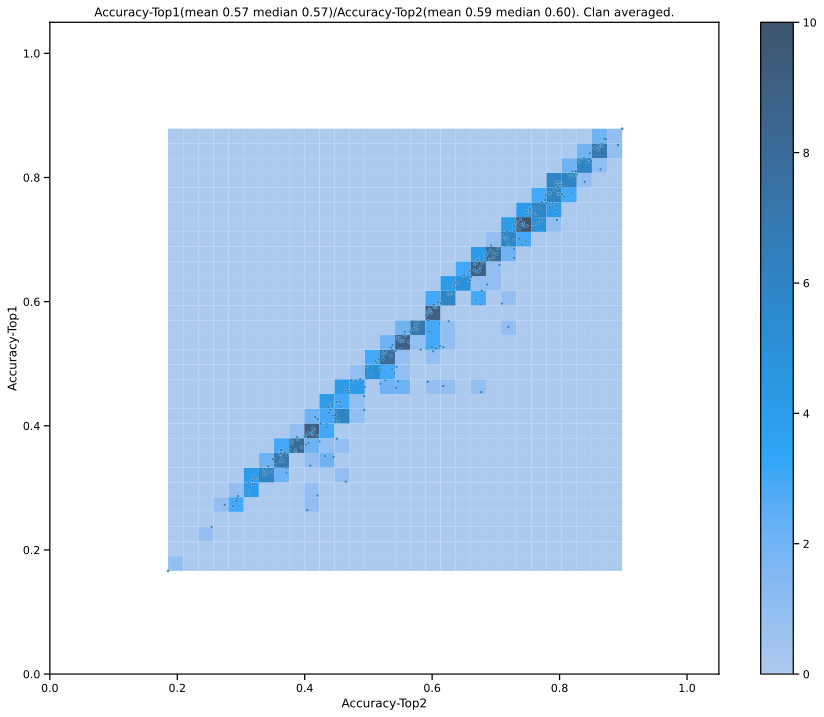

In [2]:

import numpy as np
np.random.seed(0) 
from sklearn import linear_model
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import top_k_accuracy_score


User_Task = 'SXPR'
User_ClusterType = "Mmseq"






# ===== Fixed
DIR_DerivedData = "../Database-PDB/DerivedData/"
DIR_Typi = "../Database-PDB/typi/"
DIR_FuelInput = "../Database-PDB/feature/"

n_CrossFold = 9
User_featuretype = 'altman'
n_row_maxhold = 10000




CvFoldDf = pd.read_pickle(DIR_DerivedData + "/3CvFoldReference_%s_%s_%s.pkl" %(User_Task, User_ClusterType, 90))
grandbenchmark_df  =CvFoldDf.drop(columns=["Class_HaloIndex_%s" %(i_class) for i_class in range(4)])



if User_ClusterType == "Mmseq":
    from NucleicNet.DatasetBuilding.commandDataFetcherMmseq import FetchIndex, FetchTask, FetchDataset, TEMPLATE_TaskNameLabelLogicDict
else:
    from NucleicNet.DatasetBuilding.commandDataFetcher import FetchIndex, FetchTask, FetchDataset, TEMPLATE_TaskNameLabelLogicDict



TaskNameLabelLogicDict = TEMPLATE_TaskNameLabelLogicDict()


FetchIndexC = FetchIndex(DIR_Feature = DIR_FuelInput, 
                        DIR_Typi =  DIR_Typi, n_row_maxhold =  n_row_maxhold)



with open(DIR_DerivedData + "Feature.IPCA.altman.AUCG.pkl", "rb") as fn: 
    IPCA = pickle.load(fn)
IPCA_Std = (IPCA.var_)**0.5 # NOTE The statistics are caclaulted from AUCG (we avoided collecting it from all datapoints as it was swamped with nonsites), but can be applied to any dataset. There is no Feature.IPCA.altman.SXPR.pkl


print(grandbenchmark_df.shape)


# Clamp 2* datalimit
# 3 10 max5 0.24


# Clamp 1.5*datalimit
# 3 10 max10 0.32
# 3 10 max5  0.59
# 3 10 max2  0.55


# Clamp 1*datalimit
# 3 10 max5 0.32

for test_fold in [0,1,2,]:

    # ===============================
    # User insert model here
    # ===============================
    SGDClassifierC = linear_model.SGDClassifier(loss='hinge', penalty='l2', 
                                            alpha=0.0001, l1_ratio=0.15, fit_intercept=True,  shuffle=False, verbose=0, 
                                            epsilon=0.1, n_jobs=1, random_state=None, learning_rate='optimal', 
                                            eta0=0.0, power_t=0.5, class_weight=None, warm_start=False)

    # ================================
    # Training
    # ================================
    traindf = CvFoldDf.loc[CvFoldDf['3CVCrossFoldIndex'] != test_fold]
    #print(traindf.shape[0])
    #continue
    jj = 0
    flush_x = []
    flush_y = []
    flush_samplingweight = []
    for retrain_cycle in tqdm.tqdm(range(3)): 
        
        for row_i , row in traindf.iterrows():
            if jj > int(traindf.shape[0] * 1.5) :  # NOTE From experience after that the performance deteriorates
                continue
            
            # NOTE Training 
            genericfn = row['GenericFilename']
            currentfold = row['3CVCrossFoldIndex']
            n_class = len(TaskNameLabelLogicDict[User_Task])
            # ===================
            # Retrieve label feature
            # ======================
            y = []
            x = []
            sampling_weight = []
            
            for i_class in range(n_class):

                indicesretrieve = row["Class_HaloIndex_%s" %(i_class)]


                if len(indicesretrieve) == 0:
                    continue

                indicesretrieve = np.array(indicesretrieve, dtype=np.int32)
                # NOTE Downscale the nonsite in training if necessary.
                
                if i_class == 1:

                    if len(indicesretrieve) > max([
                                                len(row["Class_HaloIndex_%s" %(0)]),
                                                len(row["Class_HaloIndex_%s" %(2)]), 
                                                len(row["Class_HaloIndex_%s" %(3)])]) * 5:

                        init_len_ = len(indicesretrieve)

                        maximum_otherclass = max([
                                                len(row["Class_HaloIndex_%s" %(0)]),
                                                len(row["Class_HaloIndex_%s" %(2)]), 
                                                len(row["Class_HaloIndex_%s" %(3)])]) * 5

                        indicesretrieve = np.sort(indicesretrieve[np.random.randint(0, high=init_len_ , size=maximum_otherclass, dtype=int)])
                

                y.extend([i_class for ii in range(len(indicesretrieve))])

                # NOTE Retrieval of vectors
                feat = FetchIndexC.UTIL_Index_Feature(indicesretrieve, 
                                                        pdbid = genericfn, featuretype = "altman", ReturnDense = True)
                x.append(feat)


                #sys.exit()
            x = np.concatenate(x, axis= 0)
            x /= IPCA_Std.flatten()
            x = np.nan_to_num(x, nan = 0.0, posinf = 0.0, neginf = 0.0)
            y = np.array(y, dtype=np.int32)
            sampling_weight = compute_sample_weight(class_weight = None, y = y)
                   

            flush_x.append(x)
            flush_y.append(y)
            flush_samplingweight.append(sampling_weight)

            if jj %10 == 0:
                #print("FLUSSSHHH jj %s r cycle %s" %(jj, retrain_cycle))
                x = np.concatenate(flush_x, axis = 0)
                y = np.concatenate(flush_y, axis = 0)
                # NOTE Placing sampling weight here is very important as the dataset is highly imbalanced.
                sampling_weight = compute_sample_weight(class_weight = None, y = y)
                #sampling_weight = np.concatenate(flush_samplingweight, axis = 0)

                # NOTE Incremental SVM
                SGDClassifierC.partial_fit(x,y, classes =list(range(n_class)), sample_weight= sampling_weight) 
                flush_x = []
                flush_y = []
                flush_samplingweight = []
            jj +=1



    # =================================
    # Scoring Top1/2 accuracy
    # =================================
    #jj = 0
    
    for row_i , row in tqdm.tqdm(CvFoldDf.iterrows()):
        currentfold = row['3CVCrossFoldIndex']
        if currentfold != test_fold:
            continue
        #if jj > 20:
        #    continue
        genericfn = row['GenericFilename']
        currentfold = row['3CVCrossFoldIndex']
        n_class = len(TaskNameLabelLogicDict[User_Task])

        # ===================
        # Retrieve label feature
        # ======================
        y = []
        x = []
        for i_class in range(n_class):
            indicesretrieve = row["Class_HaloIndex_%s" %(i_class)]
            if len(indicesretrieve) == 0:
                continue
            y.extend([i_class for ii in range(len(indicesretrieve))])
            # NOTE Retrieval of vectors
            feat = FetchIndexC.UTIL_Index_Feature(np.array(indicesretrieve, dtype=np.int32), 
                                        pdbid = genericfn, featuretype = "altman", ReturnDense = True)
            x.append(feat)

        x = np.concatenate(x, axis= 0)
        x /= IPCA_Std.flatten()
        x = np.nan_to_num(x, nan = 0.0, posinf = 0.0, neginf = 0.0)
        y = np.array(y, dtype=np.int32)
        sampling_weight = compute_sample_weight(class_weight = None, y = y)


        y_pred = SGDClassifierC.predict(x)
        ypred_onehot = np.zeros((y.shape[0], n_class), dtype =np.int32)
        ypred_onehot[np.arange(y_pred.shape[0]), y_pred] = 1

        # NOTE Top accuracys
        top1 = top_k_accuracy_score(y, ypred_onehot, k=1, normalize=True, sample_weight=sampling_weight, labels=list(range(n_class)))
        top2 = top_k_accuracy_score(y, ypred_onehot, k=2, normalize=True, sample_weight=sampling_weight, labels=list(range(n_class)))
        grandbenchmark_df.loc[row_i, "Accuracy-Top1"] = top1
        grandbenchmark_df.loc[row_i, "Accuracy-Top2"] = top2
        #print(top1,top2)
        #print(score) # NOTE which accuracy is it?

        #jj +=1
    
    del SGDClassifierC
    gc.collect()
    

plt.figure(figsize = (15,12))
g = sns.histplot(data=grandbenchmark_df, y="Accuracy-Top1", x="Accuracy-Top2", kde=False, bins = 30, palette='YlGnBu', thresh = None, cbar = True)
sns.scatterplot(data=grandbenchmark_df, y="Accuracy-Top1", x="Accuracy-Top2", 
                marker = 'o', s = 8.0, alpha = 0.8)

plt.title("Accuracy-Top1(mean %.2f median %.2f)/Accuracy-Top2(mean %.2f median %.2f). All Entries." %(
                    grandbenchmark_df["Accuracy-Top1"].mean(),grandbenchmark_df["Accuracy-Top1"].median(),
                    grandbenchmark_df["Accuracy-Top2"].mean() ,grandbenchmark_df["Accuracy-Top2"].median() ))
plt.xlim((0,1.05))
plt.ylim((0,1.05))
plt.show()

# ===================
# Clan averaged
# ==================
grandbenchmark_df_ClanGrouped = grandbenchmark_df.groupby(by=["SequenceHomology_Clan"] ).agg('mean').reset_index()


plt.figure(figsize = (15,12))
g = sns.histplot(data=grandbenchmark_df_ClanGrouped, y="Accuracy-Top1", x="Accuracy-Top2", kde=False, bins = 30, palette='YlGnBu', thresh = None, cbar = True)
sns.scatterplot(data=grandbenchmark_df_ClanGrouped, y="Accuracy-Top1", x="Accuracy-Top2", 
                marker = 'o', s = 8.0, palette='husl', alpha = 0.8)

plt.title("Accuracy-Top1(mean %.2f median %.2f)/Accuracy-Top2(mean %.2f median %.2f). Clan averaged." %(
                    grandbenchmark_df_ClanGrouped["Accuracy-Top1"].mean(), grandbenchmark_df_ClanGrouped["Accuracy-Top1"].median(),
                    grandbenchmark_df_ClanGrouped["Accuracy-Top2"].mean(),grandbenchmark_df_ClanGrouped["Accuracy-Top2"].median()))
plt.xlim((0,1.05))
plt.ylim((0,1.05))
plt.show()



# Epilogue

Thank you for your interest in NucleicNet! Hope to see you all in the future.